<a href="https://colab.research.google.com/github/mhuertascompany/Saas-Fee/blob/main/hands-on/chapter3/deblending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galaxy deblending with Deep Convolutional Encoder-Decoders

##### Alexandre Boucaud & Marc Huertas-Company

In astronomical images, especially in deep surveys such as EUCLID, the projection effects may cause two or more galaxies to overlap. When they are barely indistinguishable from one another, they are referred to as _blended_ and this can bias astrophysical estimators such as the morphology of galaxies or the shear.  

As the sensitivity of imaging devices grows, a high fraction of galaxies appear _blended_ in the images (LSST estimate around ~50%-70%), which is a known and important issue for current and upcoming galaxy surveys.  

There are many approaches to deblending (separating ovelapping galaxies). The goal of this notebook is to illustrate how a particular deep network architecture called Convotuional Encoder-Decoder can approach the problem.

For the purpose of this example, we use a simplfied dataset as in [Boucaud+19](http://adsabs.harvard.edu/abs/2019arXiv190501324B). We use a set of observed isolated galaxies with HST that we artificially overlap. We therefore know the positions of the original galaxies before adding them and we can use this information for training.

We keep always one galaxy in the center of the stamp and the second one can be in any position within the stamp.  All blended stamps contain only 2 galaxies. The goal of this tutorial is to set up an Encoder-Decoder to recover the pixels belonging to the companion galaxy. See example below.

The goal here is to isolate from the image of overalpping galaxies, the pixels which belong ONLY to the companion galaxy.


![](https://drive.google.com/uc?id=1m5v14u4aKVtn3QBMXx4GcZqMjt5gRWSO)

---



#### Before we start, make sure to open this Colab notebook in "PlayGround Mode" (top left) and to change the Runtime type to GPU by navigating to the toolbar and clicking Runtime -> Change runtime type and then changing Hardware accelerator to GPU

---

In [ ]:
import os
import sys
import tarfile
from urllib.request import urlretrieve
import tensorflow as tf
from keras.callbacks import TensorBoard


import numpy as np
import matplotlib.pyplot as plt
import pdb

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data download and preparation

Before mounting the drive click on [this folder](https://drive.google.com/drive/folders/1PcftgBzBySo1Ync-Wdsp9arTCJ_MfEPE?usp=sharing) and add it to your google drive by following these steps:

*   Go to your drive
*   Find shared folder ("Shared with me" link)
*   Right click it
*   Click Add to My Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load data

In [ ]:
suffix = ""
pathinData="/content/drive/My Drive/ED_127_2023/deblending"

X_train = np.load(os.path.join(pathinData, f"train_blends{suffix}.npy"), mmap_mode='r')
Y_train = np.load(os.path.join(pathinData, f"train_target_masks{suffix}.npy"), mmap_mode='r')[:, 1, :, :]

X_test = np.load(os.path.join(pathinData, f"test_blends{suffix}.npy"), mmap_mode='r')
Y_test = np.load(os.path.join(pathinData, f"test_target_masks{suffix}.npy"), mmap_mode='r')[:, 1, :, :]

### Plot a random example
Run multiple times to see more than one example. The left panel shows the image with 2 overlapping galaxies. The right panel shows the target segmentation mask we want to achieve. Only the pixels belonging to the companion are set to 1, the rest of the image is set to 0.

(2000, 128, 128)


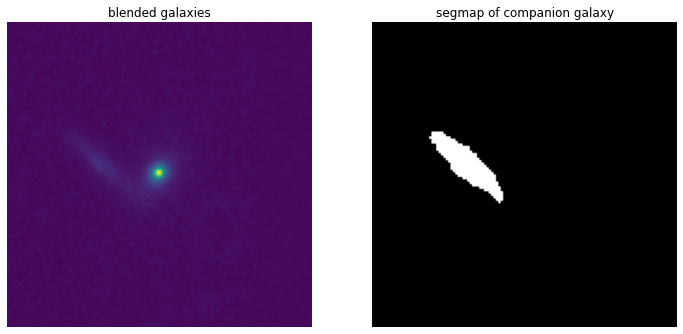

In [ ]:
def plot_data_basic(idx):
    titles = [
        'blended galaxies',
        'segmap of companion galaxy'
    ]

    fig_size = (12, 6)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=fig_size)
    axes[0].imshow(X_train[idx], cmap='viridis')
    axes[1].imshow(Y_train[idx], cmap='Greys_r')
    for title, ax in zip(titles, axes):
        ax.set_title(title)
        ax.set_axis_off()

index = np.random.randint(len(X_train))
plot_data_basic(index)
print((Y_test.shape))

## Model Setup

The following cells set up the model in TensorFlow. Try to complete with a simple encoder-decoder network first and then try more complex solutions such as U-nets. In order to code complex architectures you would need to use the API mode of TF-keras.

In [ ]:
def pack_images(images, rows, cols):
    """Helper utility to make a field of images."""
    shape = tf.shape(images)
    width = shape[-3]
    height = shape[-2]
    depth = shape[-1]
    images = tf.reshape(images, (-1, width, height, depth))
    batch = tf.shape(images)[0]
    rows = tf.minimum(rows, batch)
    cols = tf.minimum(batch // rows, cols)
    images = images[:rows * cols]
    images = tf.reshape(images, (rows, cols, width, height, depth))
    images = tf.transpose(images, [0, 2, 1, 3, 4])
    images = tf.reshape(images, [1, rows * width, cols * height, depth])
    return images


def image_tile_summary(name, tensor, rows=8, cols=8):
    tf.summary.image(name, pack_images(tensor, rows, cols), max_outputs=1)

def fcnn_model():


    input_layer = tf.keras.Input(shape=(128,128,1))

    # Convolutional Layer #1
    conv1 = tf.keras.layers.Conv2D(
      32,
      (3, 3),
      padding="same",
      activation=tf.nn.relu)(input_layer)

    pool1 = tf.keras.layers.MaxPool2D((2,2))(conv1)

    conv2 = tf.keras.layers.Conv2D(
      64,
      (3, 3),
      padding="same",
      strides=(2,2),
      activation=tf.nn.relu)(pool1)

    ## add here more layers of the encoder



    ## the decoder starts here

    ## This is the last layer

    # Deconvolutional Layer #3 (NEED TO MAKE SURE THAT THE LAST LAYER IS OF SIZE 128*128*!)

   output = tf.keras.layers.Conv2DTranspose(
      1,
      (3,3),
      padding="same",
      strides=(2,2),
      activation='sigmoid')(conv2)

    output = tf.keras.layers.Conv2DTranspose(
      1,
      (3,3),
      padding="same",
      strides=(2,2),
      activation='sigmoid')(conv2)

    #predictions = tf.nn.sigmoid(output)



    return tf.keras.Model(input_layer,output)



In [ ]:
fcnn_toy = fcnn_model()
fcnn_toy.summary()

## Training the model

In [ ]:
#Define output path - This folder will contain the trained model
pathout='deblending/models/model1'

#Set RESET=True to delete all previous runs of the same model
RESET=False
if RESET:
  os.system("rm -rf "+ pathout)


Run TensorBoard. You should see an orange panel appearing. If it's not the case, try again running the cell.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir deblending/models/fcnn1

Main training cell. You should be able to follow the training progress in the TensorBoard window above. If you click on the tab IMAGES you will see examples of output images during training.

In [ ]:
nb_epochs=50
batch_size=16

#Define output path - This folder will contain the trained model
pathout='deblending/models/fcnn1'

#define callbacks
tensorboard = TensorBoard(log_dir=pathout)

fcnn = fcnn_model()
fcnn.compile(loss='binary_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.0001))

print("Training...")
history=fcnn.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epochs,callbacks=[tensorboard])


## Evaluation of the model

For image detection a classical metric is the ***Intersection over Union (IoU)*** also referred to as ***Jaccard index*** and defined as

$$ IoU(A, B) =  \dfrac{|A \cap B|}{|A \cup B|} $$

This metric is very sensitive to small shifts or area difference between truth and prediction.

Typically, a value of IoU superior to 0.5 is used to define a good detection.

An implementation of the IoU for a series of flatten segmentation images $\in [0, 1]$ can be found below. You can just compile it.

The goal is to perform a model that gets the best IoU score.

You can enter your score [here](https://keepthescore.co/board/pvrdjsgpime/)

In [ ]:
def iou_bitmap(y_true, y_pred, verbose=False):
    """
    Compute the IoU between two arrays
    If the arrays are probabilities (floats) instead of predictions (integers
    or booleans) they are automatically rounded to the nearest integer and
    converted to bool before the IoU is computed.
    Parameters
    ----------
    y_true : ndarray
        array of true labels
    y_pred : ndarray
        array of predicted labels
    verbose : bool (optional)
        print the intersection and union separately
    Returns
    -------
    float :
        the intersection over union (IoU) value scaled between 0.0 and 1.0
    """
    EPS = np.finfo(float).eps

    # Make sure each pixel was predicted e.g. turn probability into prediction
    if y_true.dtype in [np.float32, np.float64]:
        y_true = y_true.round().astype(bool)

    if y_pred.dtype in [np.float32, np.float64]:
        y_pred = y_pred.round().astype(bool)

    # Reshape to 1d
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    # Compute intersection and union
    intersection = np.sum(y_true * y_pred)
    sum_ = np.sum(y_true + y_pred)
    jac = (intersection + EPS) / (sum_ - intersection + EPS)

    if verbose:
        print('Intersection:', intersection)
        print('Union:', sum_ - intersection)

    return jac


def iou(y_true, y_pred):
    iou_list = [iou_bitmap(yt, yp)
                for (yt, yp) in zip(y_true, y_pred)]
    return np.mean(iou_list)

Compute IoU for the current model. Can you get better than 0.8 ? Enter your result in the [leaderboard.](https://keepthescore.co/board/pvrdjsgpime/)

In [ ]:
Y_p = fcnn(X_test[0:50])

#p_mask=[]
#mask=[]
#for i in range(len(Y_test[0:50])):
#    p_mask.append(next(Y_p))
#    mask.append(Y_test[i])


s = iou(np.asarray(Y_p[0:50]).squeeze(),Y_test[0:50].squeeze())
print('IoU score:', s)

The following cell visualizes some examples.

In [ ]:
fig_size = (10, 12)
n_gal=5
fig, ax = plt.subplots(nrows=n_gal, ncols=4, figsize=fig_size)
titles = [
            'blend',
            'true segmentation',
            'output',
            'output thresholded',
        ]

for i in range(n_gal):
  img = np.squeeze(X_test[i])
  yt = np.squeeze(Y_test[i])
  yp = np.squeeze(np.asarray(Y_p)[i])
  ax[i, 0].imshow(img)
  ax[i, 1].imshow(yt)
  ax[i, 2].imshow(yp)
  ax[i, 3].imshow(yp.round())
  if i == 0:
    for idx, a in enumerate(ax[i]):
      a.set_title(titles[idx])
  for a in ax[i]:
    a.set_axis_off()